In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import calmap
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

### **读取数据**

In [10]:
df_hourly = pd.read_excel("project_data/data_beijing_air.xlsx", sheet_name="hourly_data")
df_daily = pd.read_excel("project_data/data_beijing_air.xlsx", sheet_name="daily_data")
df_monthly = pd.read_excel("project_data/data_beijing_air.xlsx", sheet_name="monthly_data")
df_region = pd.read_csv("project_data/aqi_daily_region.csv", encoding="gbk")

### **AQI数值每小时变动图**

D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plot/日内AQI变化规律图.png


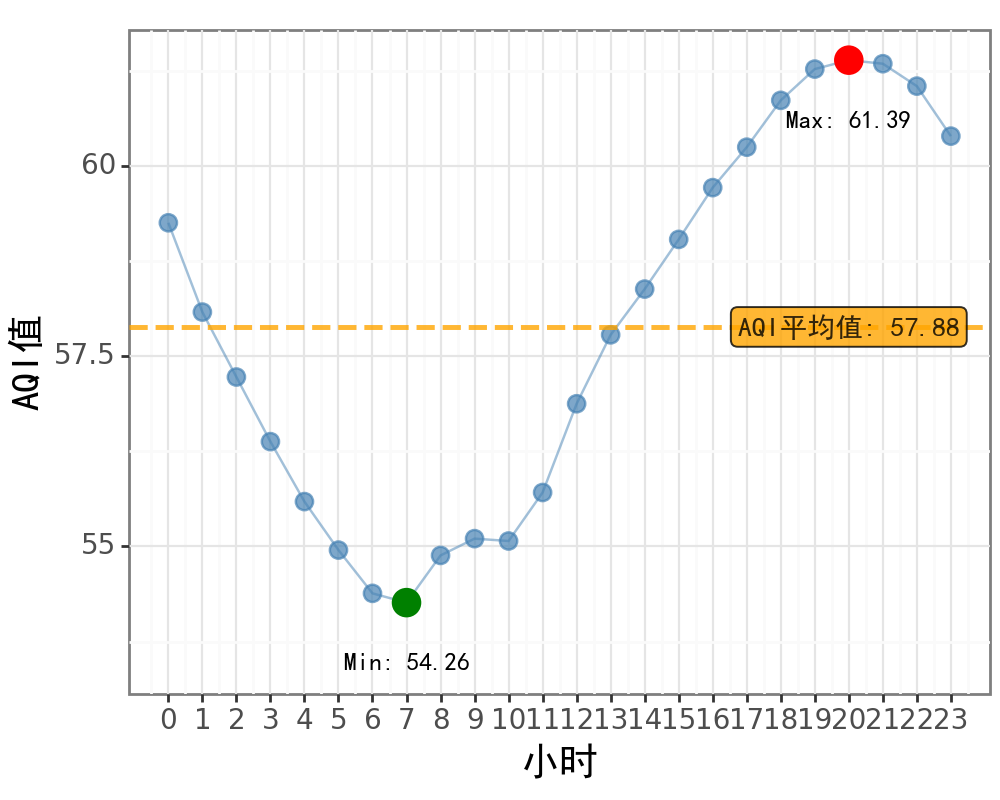

<Figure Size: (500 x 400)>

In [11]:
from plotnine.geoms.geom_segment import geom_segment

# 计算均值
hourly_avg = df_hourly.groupby('hour')['AQI'].mean().reset_index()
overall_avg = hourly_avg['AQI'].mean()
# 找到最高点和最低点
max_hour = hourly_avg.loc[hourly_avg['AQI'].idxmax()]
min_hour = hourly_avg.loc[hourly_avg['AQI'].idxmin()]
# 创建标注数据框
annotations_data = pd.DataFrame({
    'hour': [max_hour['hour'], min_hour['hour']],
    'AQI': [max_hour['AQI'], min_hour['AQI']],
    'label': [f'Max: {max_hour["AQI"]:.2f}', f'Min: {min_hour["AQI"]:.2f}'],
    'color': ['red', 'green']
})

p1 =  (
        ggplot(hourly_avg, aes(x='hour', y='AQI'))
        + geom_point(size=3, color='steelblue', alpha=0.7)  # 点图
        + geom_line(color='steelblue', alpha=0.5)  # 添加连线
        + geom_hline(yintercept=overall_avg, color='orange', linetype='dashed', size=1, alpha=0.8)  # 平均值线改为橙色
        + geom_point(data=annotations_data, mapping=aes(color='color'), size=5)
        # 极值点标注文本
        + geom_text(
            data=annotations_data,
            mapping=aes(label='label'),
            nudge_y=-0.8,  
            size=9,
            family='SimHei'
        )
        # 均值线标注 - 使用文本框
        + geom_label(
            data=pd.DataFrame({'x': [20], 'y': [overall_avg], 'label': [f'AQI平均值: {overall_avg:.2f}']}),
            mapping=aes(x='x', y='y', label='label'),
            fill='orange',
            color='black',
            alpha=0.8,
            size=10,
            family='SimHei',
        )
        + scale_x_continuous(breaks=range(0, 24)) 
        + scale_color_identity()  
        + labs(
            #title='每小时AQI数值变化', 
            x='小时', 
            y='AQI值'
        )
        + theme_bw()
        + theme(
            figure_size=(5, 4),
            plot_title=element_text(size=18, face='bold', hjust=0.5, family='SimHei'),
            axis_title_x=element_text(size=14, face='bold', family='SimHei'),
            axis_title_y=element_text(size=14, face='bold', family='SimHei'),
            axis_text_x=element_text(size=10),  
            axis_text_y=element_text(size=10)   
        )
    )
ggsave(p1, "plot/日内AQI变化规律图.png")
p1

### **AQI每日波动变化**

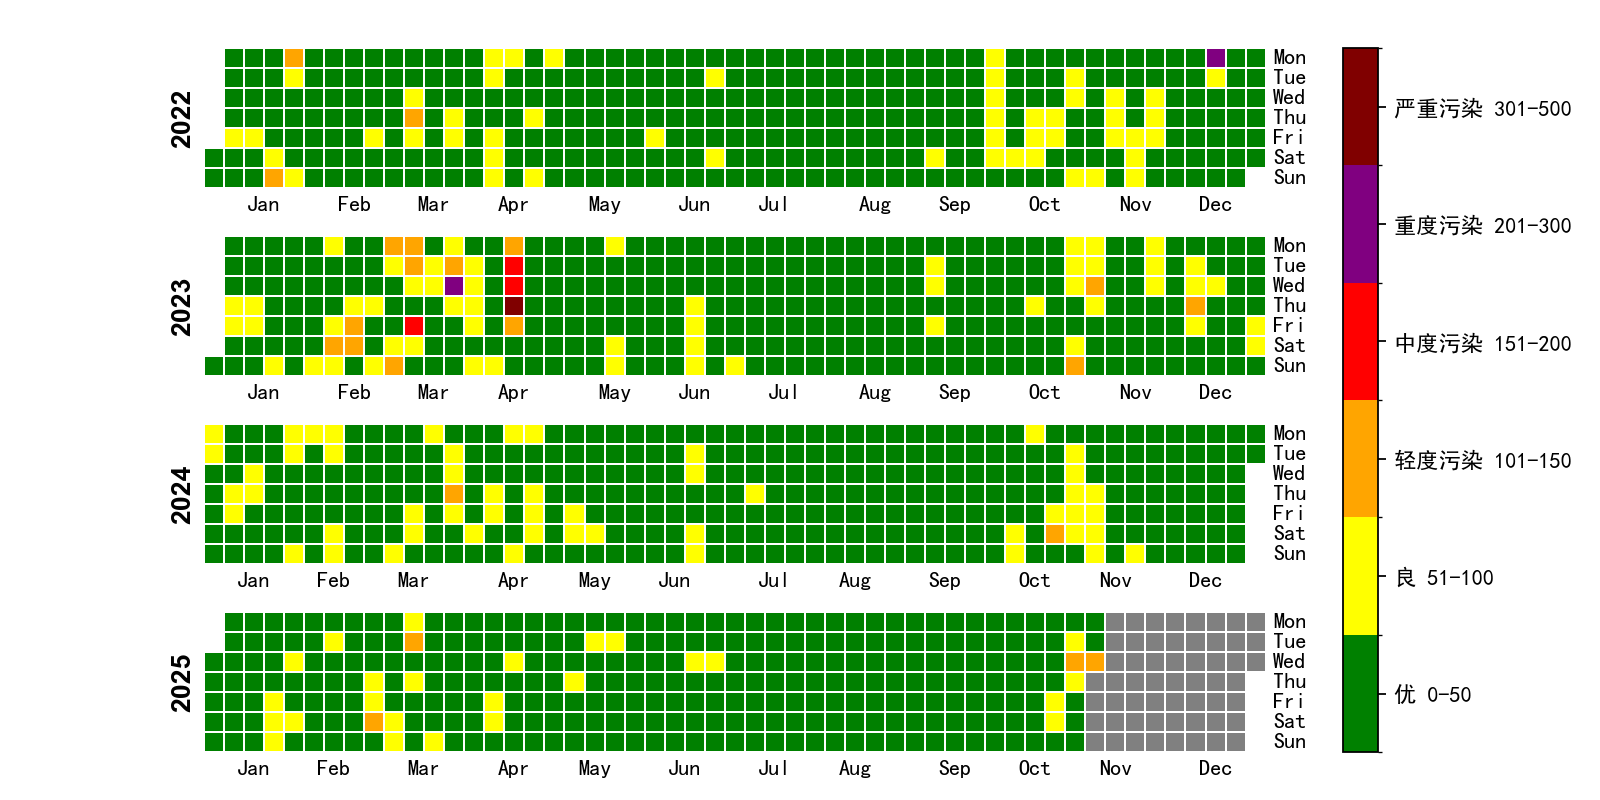

In [12]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

df1_d = df_daily.copy()
df1_d = df1_d[["date", "aqi"]]
df1_d.set_index('date', inplace=True)
df1_d.head()

# 定义AQI等级边界
aqi_bounds = [0, 50, 100, 150, 200, 300, 500]
aqi_colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']

# 创建分段颜色映射
cmap = mcolors.ListedColormap(aqi_colors)
norm = mcolors.BoundaryNorm(aqi_bounds, cmap.N)

# 绘制年历热图
fig, ax = calmap.calendarplot(
    df1_d['aqi'],
    fillcolor='grey',
    linecolor='w', 
    linewidth=0.2,
    cmap=cmap,
    vmin=0,
    vmax=500,
    yearlabel_kws={'color': 'black', 'fontsize': 12},
    fig_kws=dict(figsize=(10, 5), dpi=80)
)

# 创建自定义颜色条
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 添加颜色条
cbar = plt.colorbar(sm, ax=ax)
cbar.set_ticks([25, 75, 125, 175, 250, 400])
cbar.set_ticklabels(['优 0-50', '良 51-100', '轻度污染 101-150', '中度污染 151-200', '重度污染 201-300', '严重污染 301-500'], fontproperties='SimHei')
#cbar.set_ticklabels(['Excellent', 'Good', 'Lightly Polluted', 'Moderately Polluted', 'Heavily Polluted', 'Severely Polluted'])
plt.savefig('plot/AQI日历热力图.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### **周度AQI变化趋势**

D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plot/周内AQI变化规律图.png


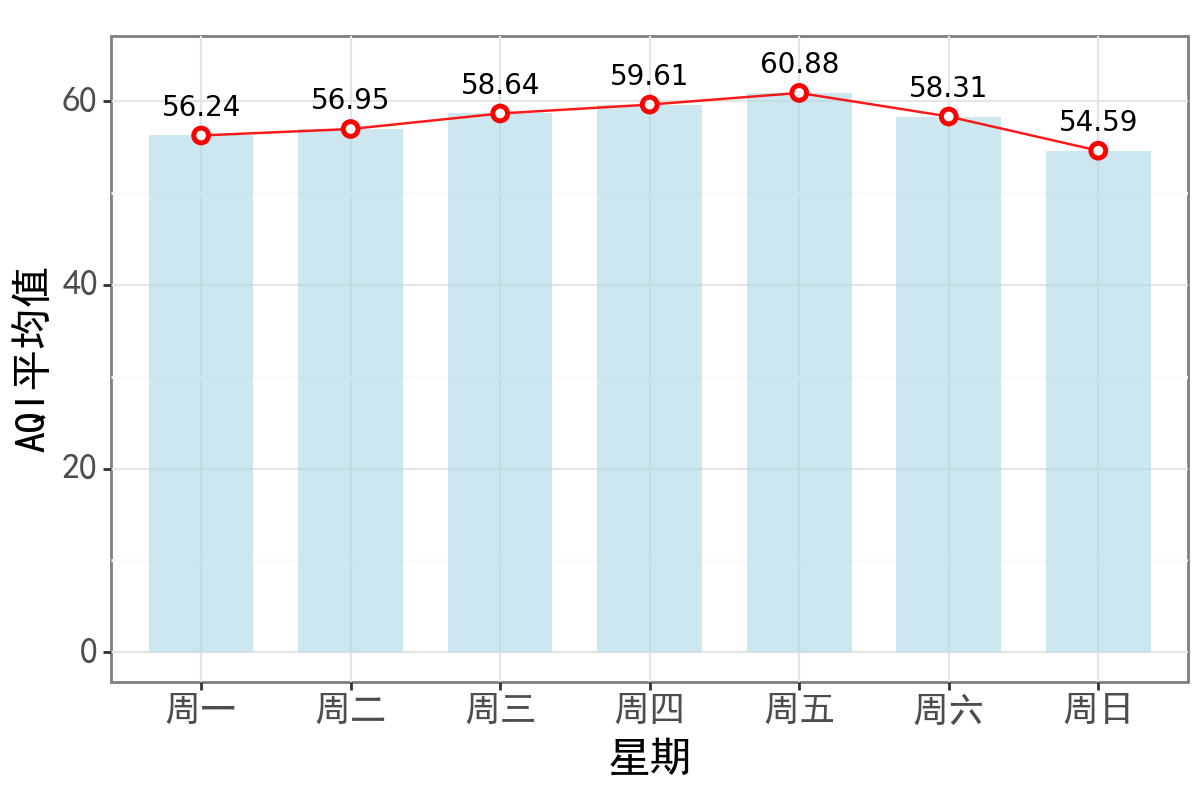

<Figure Size: (600 x 400)>

In [13]:
# 计算每周各天的AQI均值
weekday_avg = df_daily.groupby('weekday')['aqi'].mean().reset_index()

# 将weekday转换为分类变量以保持正确顺序
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_order_cn = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
weekday_avg['weekday'] = pd.Categorical(weekday_avg['weekday'], categories=weekday_order, ordered=True)
weekday_avg = weekday_avg.sort_values('weekday')
weekday_mapping = dict(zip(weekday_order, weekday_order_cn))
weekday_avg['weekday_cn'] = weekday_avg['weekday'].map(weekday_mapping)

# 绘制图表
p2 = (
        ggplot(weekday_avg, aes(x='weekday_cn', y='aqi'))
        + geom_col(fill='lightblue', alpha=0.6, width=0.7)  # 浅蓝色柱状图
        + geom_line(aes(group=1), color='red', size=0.5, alpha=0.9, linetype='solid')  # 红色折线
        + geom_point(color='red', size=2, fill='white', stroke=1)  # 白色填充的点
        # 修正：在aes中使用字符串，格式化在外部处理
        + geom_text(aes(label=weekday_avg['aqi'].apply(lambda x: f'{x:.2f}')), 
                    nudge_y=3, size=10, color='black')
        + labs(
            #title='每周各天AQI平均值对比',
            x='星期',
            y='AQI平均值'
        )
        + theme_bw()
        + theme(
            figure_size=(6, 4),
            plot_title=element_text(size=16, face='bold', hjust=0.5, family='SimHei'),
            axis_title_x=element_text(size=15, face='bold', family='SimHei'),
            axis_title_y=element_text(size=15, face='bold', family='SimHei'),
            axis_text_x=element_text(size=13, family='SimHei'),
            axis_text_y=element_text(size=13, family='SimHei')
        )
    )
ggsave(p2, "plot/周内AQI变化规律图.png")
p2

### **月度AQI变化趋势**

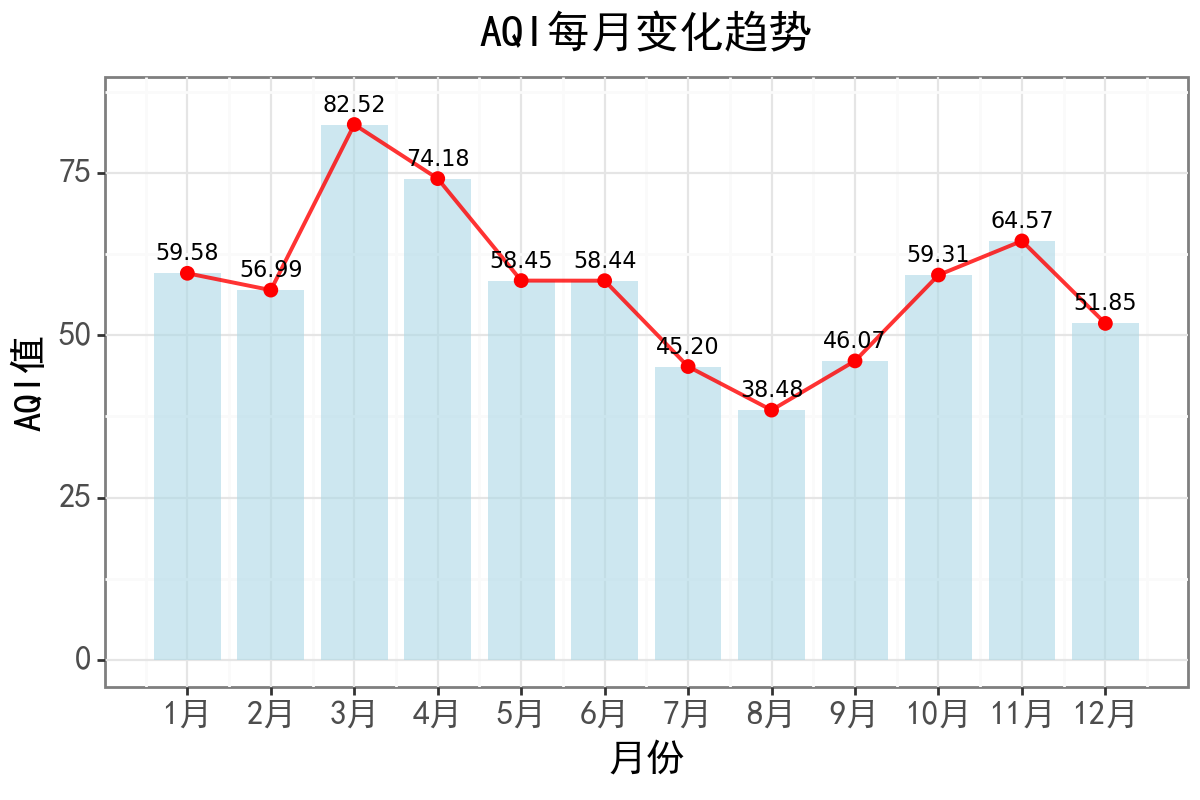

<Figure Size: (600 x 400)>

In [14]:
monthly_avg = df_monthly.groupby('month')['aqi'].mean().reset_index()
monthly_avg['aqi_label'] = monthly_avg['aqi'].apply(lambda x: f'{x:.2f}')

(
    ggplot(monthly_avg, aes(x='month', y='aqi'))
    + geom_col(fill='lightblue', alpha=0.6, width=0.8)
    + geom_line(aes(group=1), color='red', size=0.8, alpha=0.8)
    + geom_point(color='red', size=2)
    + geom_text(aes(label='aqi_label'), nudge_y=3, size=8)  # 数值标注
    + labs(
        title='AQI每月变化趋势',
        x='月份',
        y='AQI值'
    )
    # 设置x轴刻度为1-12月
    + scale_x_continuous(
        breaks=range(1, 13),  # 1到12
        labels=['1月', '2月', '3月', '4月', '5月', '6月', 
                '7月', '8月', '9月', '10月', '11月', '12月']
    )
    + theme_bw()
    + theme(
        figure_size=(6, 4),
        plot_title=element_text(size=16, face='bold', hjust=0.5, family='SimHei'),
        axis_title_x=element_text(size=14, face='bold', family='SimHei'),
        axis_title_y=element_text(size=14, face='bold', family='SimHei'),
        axis_text_x=element_text(size=12, family='SimHei'),
        axis_text_y=element_text(size=12, family='SimHei')
    )
)

### **月度AQI数据波动 小提琴图 查看数据分布波动范围**

D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
D:\Anaconda\envs\plot_env\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plot/月内AQI变化规律图.png


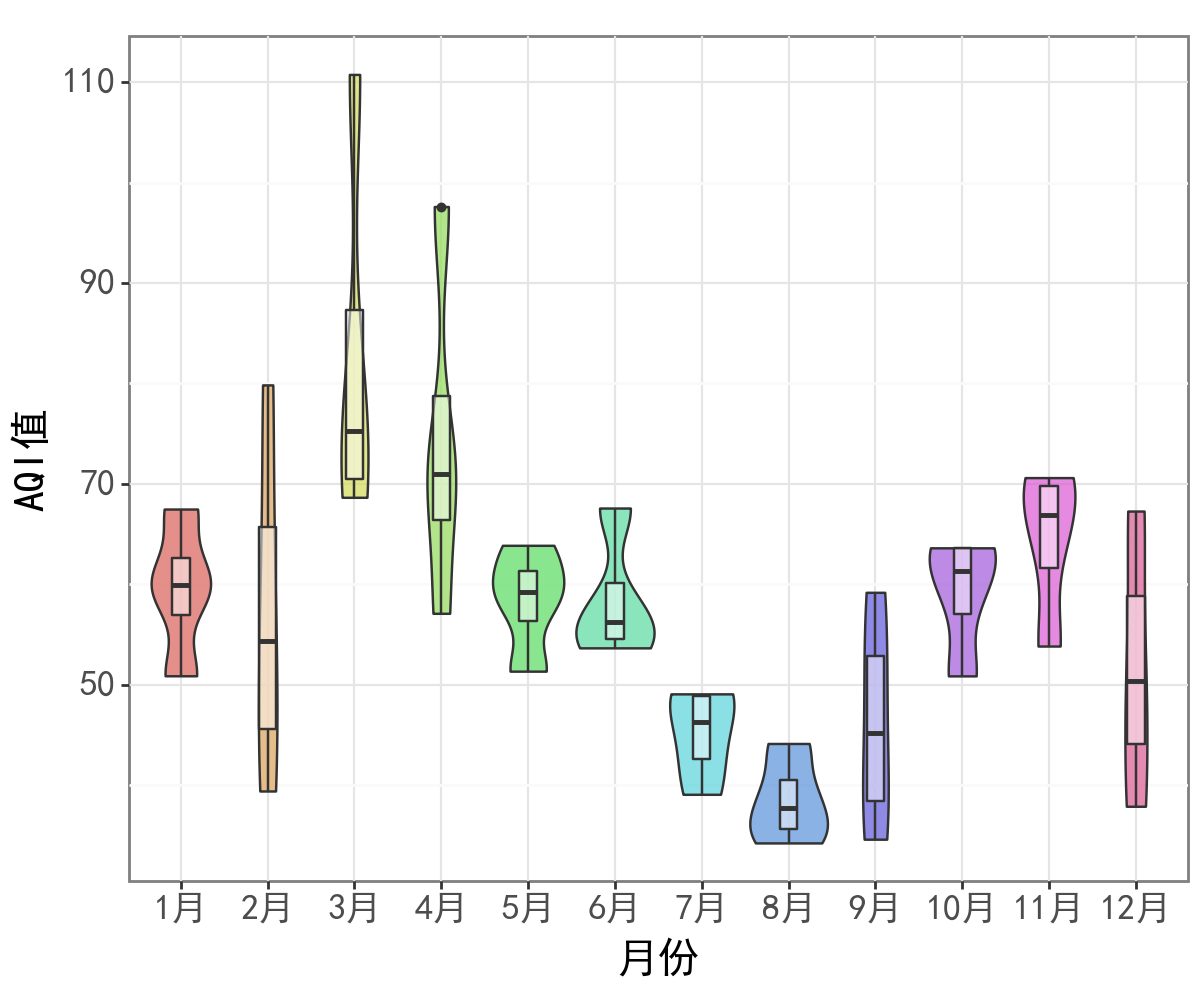

<Figure Size: (600 x 500)>

In [15]:
# 使用原始月度数据，不要groupby平均
# df_monthly 应该包含每个月的所有原始AQI数据点

p3 = (
        ggplot(df_monthly, aes(x='factor(month)', y='aqi'))
        + geom_violin(aes(fill='factor(month)'), alpha=0.7, show_legend=False)
        + geom_boxplot(width=0.2, alpha=0.5, outlier_size=1)
        + labs(
           # title='AQI月度分布（小提琴图）',
            x='月份',
            y='AQI值'
        )
        + scale_x_discrete(
            labels=['1月', '2月', '3月', '4月', '5月', '6月', 
                    '7月', '8月', '9月', '10月', '11月', '12月']
        )
        + theme_bw()
        + theme(
            figure_size=(6, 5),
            plot_title=element_text(size=16, face='bold', hjust=0.5, family='SimHei'),
            axis_title_x=element_text(size=15, face='bold', family='SimHei'),
            axis_title_y=element_text(size=15, face='bold', family='SimHei'),
            axis_text_x=element_text(size=13, family='SimHei'),
            axis_text_y=element_text(size=13, family='SimHei')
        )
    )
ggsave(p3, "plot/月内AQI变化规律图.png")
p3

In [16]:
# 定义污染等级函数
def get_pollution_level(aqi):
    if aqi <= 50:
        return '优'
    elif aqi <= 100:
        return '良'
    elif aqi <= 150:
        return '轻度污染'
    elif aqi <= 200:
        return '中度污染'
    elif aqi <= 300:
        return '重度污染'
    else:
        return '严重污染'

# 区域列表
regions = ['城六区', '西北部', '东北部', '东南部', '西南部']
levels = ['优', '良', '轻度污染', '中度污染', '重度污染', '严重污染']

In [17]:
# 统计每个区域在各污染等级的天数
region_stats = {}

for region in regions:
    aqi_values = df_region[region]
    
    # 统计各等级天数
    level_counts = {level: 0 for level in levels}
    for aqi in aqi_values:
        level = get_pollution_level(aqi)
        level_counts[level] += 1
    
    # 计算百分比
    total_days = len(aqi_values)
    level_percentages = {level: (count/total_days)*100 for level, count in level_counts.items()}
    
    region_stats[region] = {
        'counts': level_counts,
        'percentages': level_percentages
    }

print("\n各区域污染等级统计:")
for region, stats in region_stats.items():
    print(f"\n{region}:")
    for level in levels:
        print(f"  {level}: {stats['counts'][level]}天 ({stats['percentages'][level]:.1f}%)")


各区域污染等级统计:

城六区:
  优: 695天 (49.5%)
  良: 567天 (40.4%)
  轻度污染: 98天 (7.0%)
  中度污染: 32天 (2.3%)
  重度污染: 8天 (0.6%)
  严重污染: 5天 (0.4%)

西北部:
  优: 831天 (59.1%)
  良: 473天 (33.7%)
  轻度污染: 73天 (5.2%)
  中度污染: 19天 (1.4%)
  重度污染: 6天 (0.4%)
  严重污染: 3天 (0.2%)

东北部:
  优: 796天 (56.7%)
  良: 487天 (34.7%)
  轻度污染: 92天 (6.5%)
  中度污染: 22天 (1.6%)
  重度污染: 5天 (0.4%)
  严重污染: 3天 (0.2%)

东南部:
  优: 627天 (44.6%)
  良: 604天 (43.0%)
  轻度污染: 122天 (8.7%)
  中度污染: 38天 (2.7%)
  重度污染: 9天 (0.6%)
  严重污染: 5天 (0.4%)

西南部:
  优: 739天 (52.6%)
  良: 539天 (38.4%)
  轻度污染: 90天 (6.4%)
  中度污染: 24天 (1.7%)
  重度污染: 9天 (0.6%)
  严重污染: 4天 (0.3%)


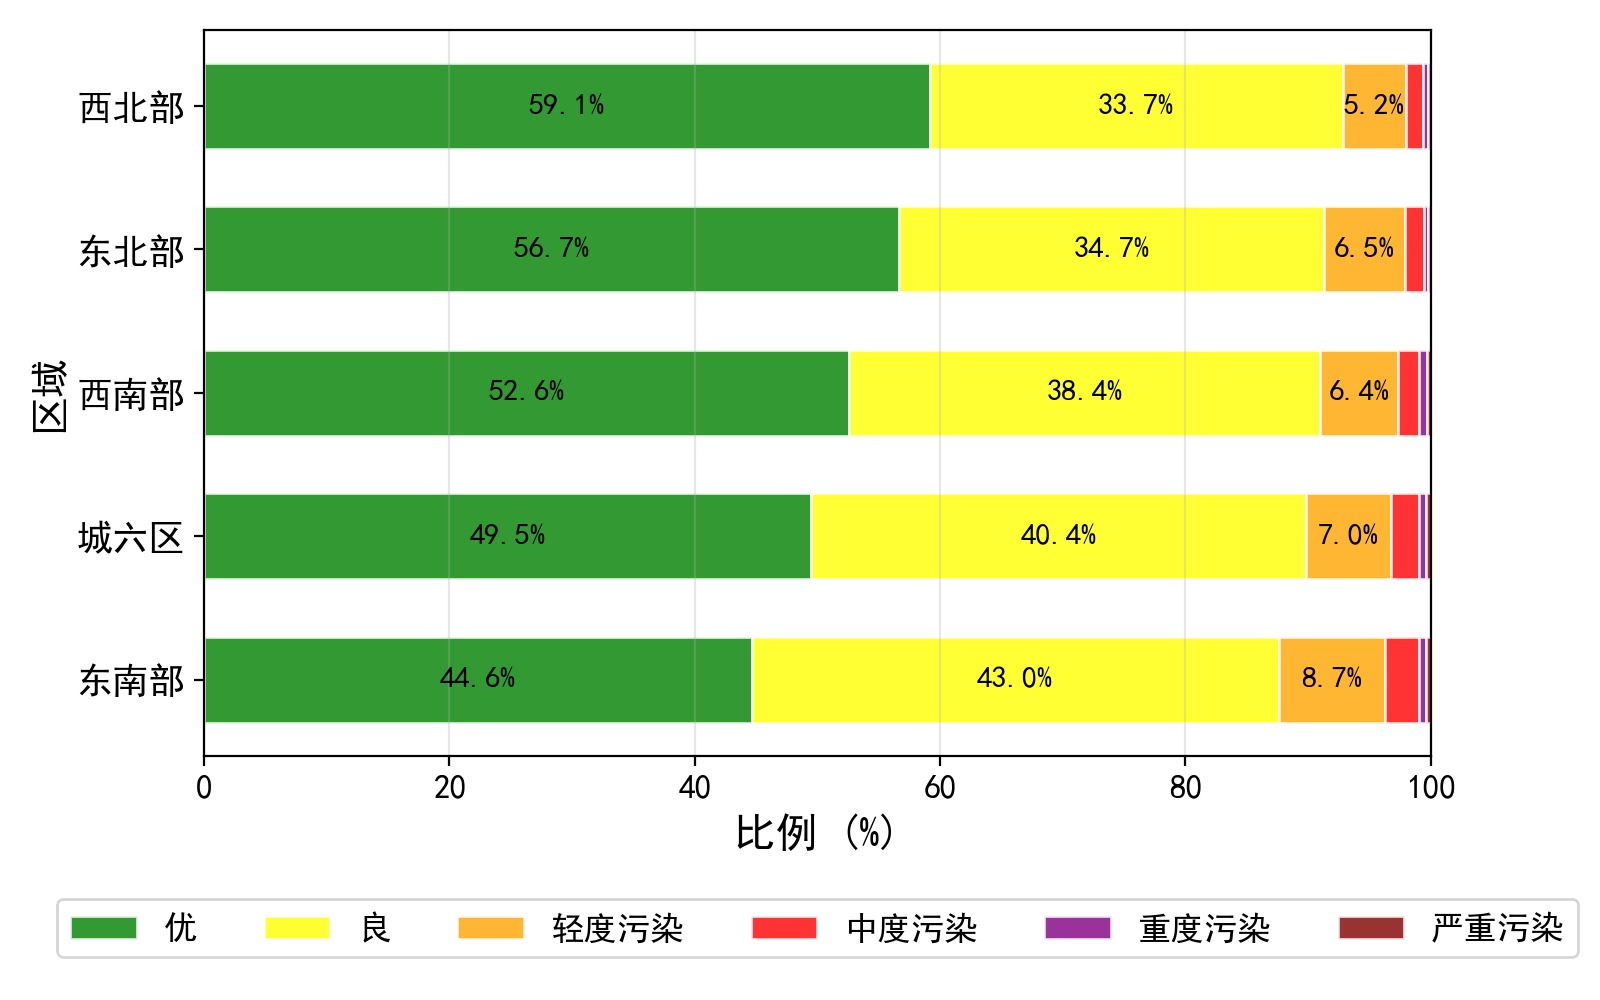

In [18]:
# 设置颜色
colors = {
    '优': 'green',           # 绿色
    '良': 'yellow',          # 黄色
    '轻度污染': 'orange',     # 橙色
    '中度污染': 'red',       # 红色
    '重度污染': 'purple',    # 紫色
    '严重污染': 'maroon'     # 栗色
}

# 计算各区域的优等级比例并排序
excellent_rates = []
for region in regions:
    excellent_rate = region_stats[region]['percentages']['优']
    excellent_rates.append((region, excellent_rate))

# 按优比例从高到低排序
excellent_rates.sort(key=lambda x: x[1], reverse=False)
sorted_regions = [item[0] for item in excellent_rates]
sorted_excellent_rates = [item[1] for item in excellent_rates]

# 重新排列堆叠数据矩阵
sorted_percentages_matrix = []
for region in sorted_regions:
    row = [region_stats[region]['percentages'][level] for level in levels]
    sorted_percentages_matrix.append(row)

sorted_percentages_matrix = np.array(sorted_percentages_matrix)

# 创建图形 - 横向布局
fig, ax = plt.subplots(figsize=(8, 5))

# 绘制堆叠柱状图 - 横向，按优比例排序
left = np.zeros(len(sorted_regions))
for i, level in enumerate(levels):
    ax.barh(sorted_regions, sorted_percentages_matrix[:, i], left=left, 
            label=level, color=colors[level], alpha=0.8, 
            edgecolor='white', linewidth=1, height=0.6)
    left += sorted_percentages_matrix[:, i]

# 设置图形属性 - 调整字体大小
ax.set_xlabel('比例 (%)', fontsize=15)
ax.set_ylabel('区域', fontsize=14)
#ax.set_title('北京各区域空气质量等级分布对比', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=13)
ax.legend(bbox_to_anchor=(0.5, -0.3), loc='lower center', 
          fontsize=12, ncol=6)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 100)

# 添加数据标签
for i, region in enumerate(sorted_regions):
    total_width = 0
    for j, level in enumerate(levels):
        width = sorted_percentages_matrix[i, j]
        if width > 5:
            ax.text(total_width + width/2, i, f'{width:.1f}%', 
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    color='black')
        total_width += width


plt.tight_layout()
plt.savefig('plot/北京各区域空气质量等级分布对比.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()



### **2022-2024年各区域aqi值对比**

In [19]:
aqi_monthly = pd.read_csv("project_data/aqi_monthly.csv", encoding="gbk")
columns = ['year', '北京', '城六区', '西北部', '东北部', '东南部', '西南部']
aqi_monthly = aqi_monthly[columns]
aqi_monthly.head()

,year,北京,城六区,西北部,东北部,东南部,西南部
0,2022,67.499714,68.940000,60.564,64.16875,74.695000,67.7175
1,2022,39.428571,40.150833,35.602,37.12125,44.538333,38.9950
2,2022,68.668571,71.328333,65.520,63.14000,71.566667,71.3350
3,2022,69.508000,70.755000,64.286,66.70500,73.858333,71.3750
4,2022,51.357429,52.565000,47.104,49.39625,54.833333,51.7600


In [20]:
aqi_yearly_means = aqi_monthly.groupby('year').mean().round(2)
print(aqi_yearly_means)

         北京    城六区    西北部    东北部    东南部    西南部
year                                          
2022  56.42  58.13  51.78  52.92  61.40  56.65
2023  66.24  68.15  60.94  63.13  73.64  62.24
2024  57.14  59.35  51.38  52.90  61.64  58.90
2025  52.10  53.86  46.47  47.96  58.06  53.22


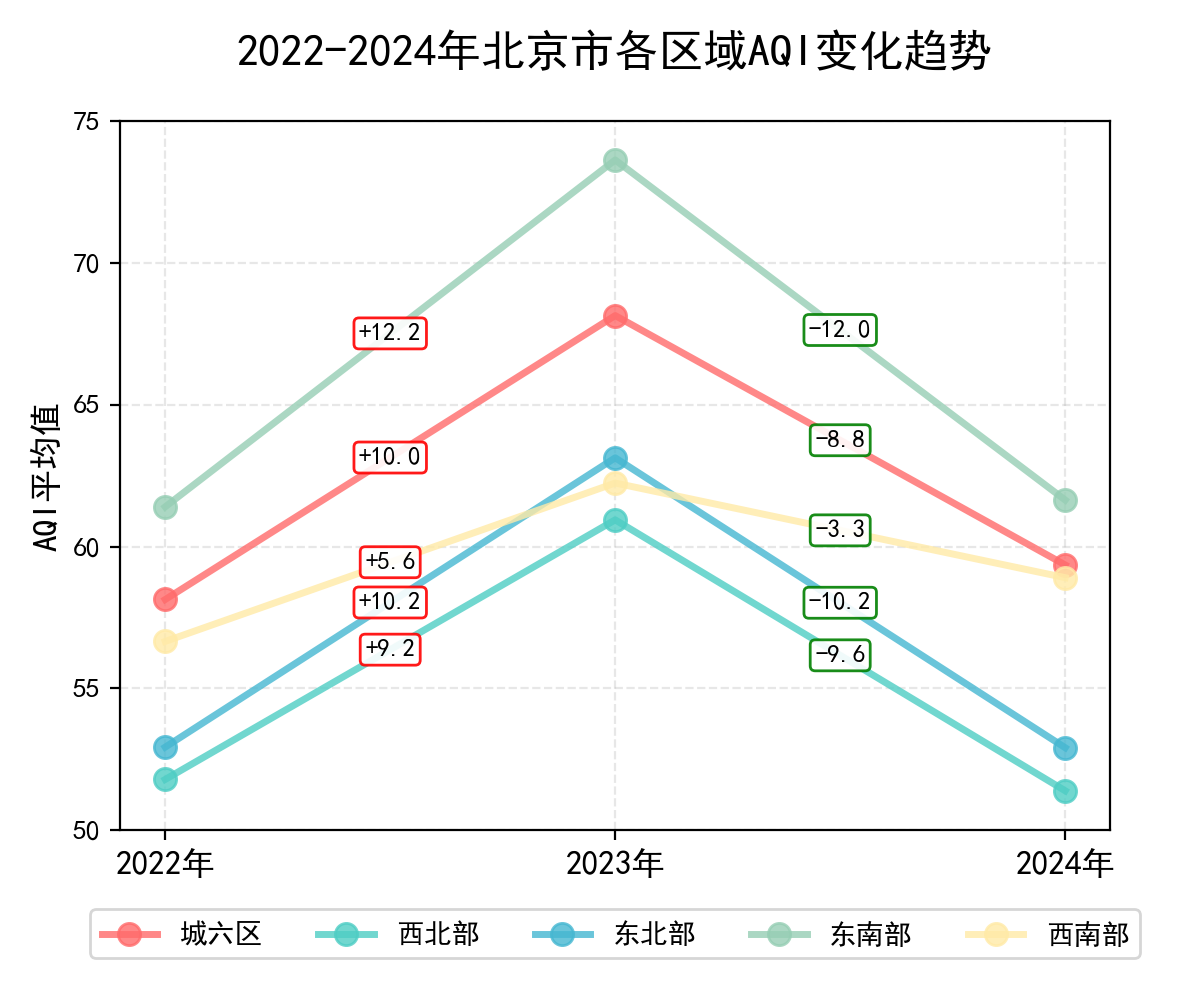

In [21]:
data = {
    '区域': ['城六区', '西北部', '东北部', '东南部', '西南部'],
    '2022': [58.13, 51.78, 52.92, 61.40, 56.65],
    '2023': [68.15, 60.94, 63.13, 73.64, 62.24],
    '2024': [59.35, 51.38, 52.90, 61.64, 58.90]
}
df = pd.DataFrame(data)

region_colors = {
    '城六区': '#FF6B6B',      # 红色
    '西北部': '#4ECDC4',      # 青色
    '东北部': '#45B7D1',      # 蓝色
    '东南部': '#96CEB4',      # 绿色
    '西南部': '#FFEAA7'       # 黄色
}

plt.figure(figsize=(6, 5))
years = ['2022', '2023', '2024']
x_pos = [0, 1, 2]

# 为每个区域绘制连线
for i, region in enumerate(df['区域']):
    values = [df.loc[i, year] for year in years]
    color = region_colors[region]
    
    # 绘制连线
    plt.plot(x_pos, values, marker='o', linewidth=2.5, markersize=8, 
             color=color, label=region, alpha=0.8, markerfacecolor=color)
    
    # 标注变化量
    for j in range(1, len(years)):
        change = values[j] - values[j-1]
        change_color = 'red' if change > 0 else 'green'
        change_symbol = '+' if change > 0 else ''
        plt.text(x_pos[j]-0.5, (values[j] + values[j-1])/2, 
                f'{change_symbol}{change:.1f}', 
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                         edgecolor=change_color, alpha=0.9))

plt.xticks(x_pos, [f'{year}年' for year in years], fontsize=12)
plt.ylabel('AQI平均值', fontsize=12)
plt.title('2022-2024年北京市各区域AQI变化趋势', fontsize=16, pad=20)
plt.grid(True, alpha=0.3, linestyle='--')

# 设置y轴范围，使图表更紧凑
plt.ylim(50, 75)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), 
           ncol=5, frameon=True)
plt.tight_layout()
plt.show()